Note that I do not have the original reference for the code in the next cell.  If you know of the source and/or are the author, please contact me and I will update the citation for this function.

In [1]:
%matplotlib inline
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# You can change the default figure size to be a bit larger if you want,
# uncomment the next line for that:
plt.rc('figure', figsize=(10, 6))

def plot_taylor_approximations(func, x0=None, orders=(2, 4), xrange=(0,1), yrange=None, npts=200):
    """Plot the Taylor series approximations to a function at various orders.

    Parameters
    ----------
    func : a sympy function
    x0 : float
      Origin of the Taylor series expansion.  If not given, x0=xrange[0].
    orders : list
      List of integers with the orders of Taylor series to show.  Default is (2, 4).
    xrange : 2-tuple or array.
      Either an (xmin, xmax) tuple indicating the x range for the plot (default is (0, 1)),
      or the actual array of values to use.
    yrange : 2-tuple
      (ymin, ymax) tuple indicating the y range for the plot.  If not given,
      the full range of values will be automatically used. 
    npts : int
      Number of points to sample the x range with.  Default is 200.
    """
    if not callable(func):
        raise ValueError('func must be callable')
    if isinstance(xrange, (list, tuple)):
        x = np.linspace(float(xrange[0]), float(xrange[1]), npts)
    else:
        x = xrange
    if x0 is None: x0 = x[0]
    xs = sp.Symbol('x')
    # Make a numpy-callable form of the original function for plotting
    fx = func(xs)
    f = sp.lambdify(xs, fx, modules=['numpy'])
    # We could use latex(fx) instead of str(), but matploblib gets confused
    # with some of the (valid) latex constructs sympy emits.  So we play it safe.
    plt.plot(x, f(x), label=str(fx), lw=2)
    # Build the Taylor approximations, plotting as we go
    apps = {}
    for order in orders:
        app = fx.series(xs, x0, n=order).removeO()
        apps[order] = app
        # Must be careful here: if the approximation is a constant, we can't
        # blindly use lambdify as it won't do the right thing.  In that case, 
        # evaluate the number as a float and fill the y array with that value.
        if isinstance(app, sp.numbers.Number):
            y = np.zeros_like(x)
            y.fill(app.evalf())
        else:
            fa = sp.lambdify(xs, app, modules=['numpy'])
            y = fa(x)
        tex = sp.latex(app).replace('$', '')
        plt.plot(x, y, label=r'$n=%s:\, %s$' % (order, tex) )
        
    # Plot refinements
    if yrange is not None:
        plt.ylim(*yrange)
    plt.grid()
    plt.legend(loc='best').get_frame().set_alpha(0.8)

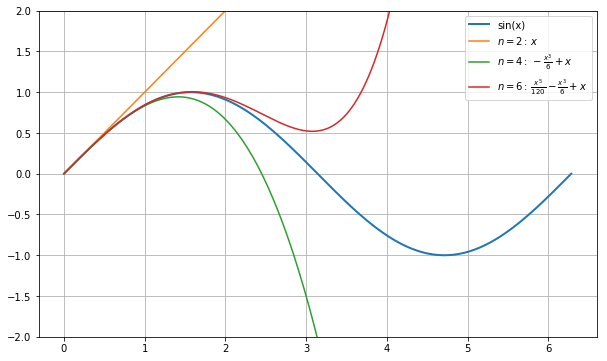

In [2]:
plot_taylor_approximations(sp.sin, 0, [2, 4, 6], (0, 2*sp.pi), (-2,2))



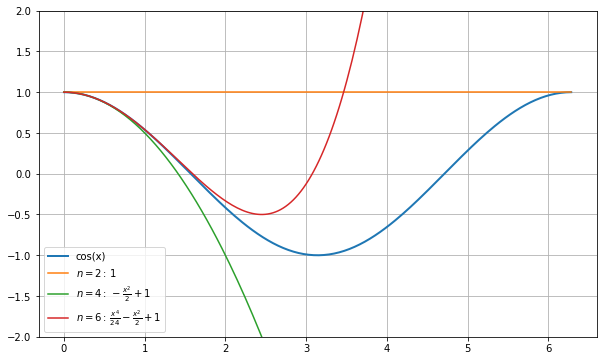

In [3]:
plot_taylor_approximations(sp.cos, 0, [2, 4, 6], (0, 2*sp.pi), (-2,2))



# Lecture 10:  Taylor's Series and Discrete Calculus

### Sections

* [Introduction](#Introduction)
* [Learning Goals](#Learning-Goals)
* [On Your Own](#On-Your-Own)
    * Deriving Taylor's Series and Helpful Functions
    * Visualizing Taylor's Series (Add code above)

### Sections (Continued)
* [In Class](#In-Class)
    * Computing Derivatives of Discrete Data
    * Symbolically Computing Forward and Backward Differences
* [Homework](#Homework)
* [Summary](#Summary)
* [Looking Ahead](#Looking-Ahead)
* [Reading Assignments and Practice](#Reading-Assignments-and-Practice)

## Introduction
-----

As described by Hornbeck in his introductory text Numerical Methods:  "The Taylor series is the foundation of numerical methods."

At this point we have demonstrated how computer algebra systems can help us work out products of matrices.  The benefit is in the way the software helps us avoid silly algebra errors.  In this lecture we synthesize the previous two concepts with Taylor series to see how the large majority of modeling in diffusive systems is performed.

## Learning Goals
----

1. Become reacquainted with the Taylor series.
1. Use the Taylor series to approximate functions and derivatives of discrete data.

## On Your Own
----

### Deriving Taylor's Series and Helpful Functions

The function $f(x)$ will be expanded into an infinite series or a finite series plus an error term.  Assume that the function has a continuous nth derivative over the interval $a \le x \le b$.  You proceed by integrating the nth derivative n times:

$$\int_a^x f^n(x) dx = f^{(n-1)}(x) - f^{(n-1)}(a)$$

and so on ...  Do this n times and then solve for f(x) to recover Taylor's series.

One of the key features in this derivation is that the integral is definite.  If the above looks strange, remeber the n is the order of differentiation, not an exponent.  This derivation is outlined on [Wolfram’s Mathworld](http://mathworld.wolfram.com/TaylorSeries.html).  Please read around this topic by visiting the site.




### A More Transparent Approach

To give us a more concrete feel for what we are doing, we are going to start differently.  Say that we wish to expand sin(x) about x=0.  First, assume that the series exists and can be written as a power series with unknown coefficients.  Differentiate the series and the function we are expanding.  Let the value of x go to the value of the expansion point and then you will get the coefficients in turn:

In [4]:
import sympy as sp
sp.init_printing()

In [5]:
x, A, B, C, D, E = sp.symbols('x, A, B, C, D, E')

To help us get our work done we can use `sympy`'s `diff` function.  Of course, you can read the documentation, but, the gist of things is that you pass a symbolic expression and the symbol for the variable you wish to differentiate with:

In [6]:
sp.diff(sp.sin(x),x)

We assume that $\sin x$ can be represented in a power series such as:

$$A+Bx+Cx^2+Dx^3+Ex^4$$.  

How can we figure out the values of ${A,B, C, D, E}$?  We can choose an expansion point (e.g. $x = 0$) and differentiate to get the coefficients.  I do this below in a few lines of code. 

Here we use a list comprehension to organize our results.  Refer back to the Python tutorials we completed if you forgot how to construct such a list.  The first element of the list is the function we want to approximate.  The second element is the power series.  

In [10]:
powerSeries = A+B*x+C*x**2+D*x**3+E*x**4
funcAndSeries = [sp.diff(a,x) for a in [sp.sin(x),powerSeries]]
funcAndSeries

And if you wanted to do all of this in one line you could do the following and using the Matrix class for ease of vewing (and other matrix functions):

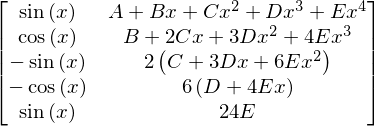

In [8]:
sp.Matrix([[sp.diff(a,x,i) \
            for a in [sp.sin(x),powerSeries]] for i in range(5)])

And if you allow a substitution where $x=0$ you can solve for the coefficients:

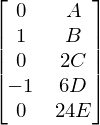

In [9]:
sp.Matrix([[sp.diff(a,x,i).subs(x,0) \
            for a in [sp.sin(x),powerSeries]] for i in range(5)])

Is there practical utility in doing this?  Well - as I wrote the above line I had already tested the results on the first three coefficients.  So - I got the last two for "free" when I finished coding the above line.  At this point what I'd probably do is functionalize and generalize the code to make a really powerful function.  For example write a function that takes any general function and differentiates it.  I'd also probably make the power series arbitrarily long - so I'd make the maximum power an input.  

However, much of this has already been done in Sympy.  See the series() function in Sympy.  To access the documentation use SHIFT-TAB to bring up the help pages.

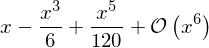

In [11]:
sp.series(sp.sin(x), x, x0=0)

To get an expression without the trailing descriptor (that indicates what order of terms are omitted) use the .removeO() method.

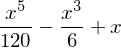

In [21]:
sp.series(sp.sin(x), x, x0=0).removeO()

Note the comparision of the coefficients to your hand calculation!  The above is really the long way around...

### DIY:  Compute a power series for an exponential function.

You just acquired some important knowledge for how to construct a series using Python.  Apply that knowledge to construct a series representation for the function $\exp(x)$.

### DIY:  How good is the small angle approximation?

In electron microscopy you often use the trigonometric function $\tan()$.  Diffraction geometry is such that the angles are very small, therefore, the approximation is often made that $\tan(2\theta)=2\theta$.  What is the error associated with this approximation in powers of the angle? 

### DIY:  Construct a Taylor series Symbolically (Explained)

Sometimes symbolic construction of a series is helpful.  Using an arbitrary function $f$, expand $f$ in $x$ about $c$.  You will need to use Sympy's "Function" object.

In [33]:
from sympy import init_printing, symbols, Function
init_printing()

x, c = symbols("x,c")
f = Function("f")

f(x).series(x, x0=c, n=3)

                                              ⎛  2        ⎞│                  
                                            2 ⎜ d         ⎟│                  
                                    (-c + x) ⋅⎜────(f(ξ₁))⎟│                  
                                              ⎜   2       ⎟│                  
                ⎛ d        ⎞│                 ⎝dξ₁        ⎠│ξ₁=c    ⎛        3
f(c) + (-c + x)⋅⎜───(f(ξ₁))⎟│     + ──────────────────────────── + O⎝(-c + x) 
                ⎝dξ₁       ⎠│ξ₁=c                2                            

        
        
        
        
       ⎞
; x → c⎠
        

There is a small bug in the Sympy printer (that comes as part of the Canopy distribution) that misses a space between the $x \rightarrow c$ above.  You can print to LaTeX and fix it yourself in the notebook if you find it distracting.  See below:

In [32]:
from sympy import series, latex
print(latex(series(f(x), x, x0=c, n=3)))

f{\left (c \right )} + \left(- c + x\right) \left. \frac{d}{d \xi_{1}} f{\left (\xi_{1} \right )} \right|_{\substack{ \xi_{1}=c }} + \frac{1}{2} \left(- c + x\right)^{2} \left. \frac{d^{2}}{d \xi_{1}^{2}}  f{\left (\xi_{1} \right )} \right|_{\substack{ \xi_{1}=c }} + \mathcal{O}\left(\left(- c + x\right)^{3}; x\rightarrowc\right)


The answer with the whitespace correction should read:  

$$f{\left (c \right )} + \left(- c + x\right) \left. \frac{d}{d \xi_{1}} f{\left (\xi_{1} \right )} \right|_{\substack{ \xi_{1}=c }} + \frac{1}{2} \left(- c + x\right)^{2} \left. \frac{d^{2}}{d \xi_{1}^{2}}  f{\left (\xi_{1} \right )} \right|_{\substack{ \xi_{1}=c }} + \mathcal{O}\left(\left(- c + x\right)^{3}; x\rightarrow c\right)$$

## In Class
----

### Computing Derivatives of Discrete Data

When you have a function that is differentible then it can be straightforward to compute it's derivative.  For example:

$$f(x) = x^2$$
$$f'(x) = 2x$$

What do I mean when I say discrete data?  In abstract terms I mean a list of values that is dependent on some other variable (like $x$):

$$\{f(x_0), f(x_1), f(x_2), ...\}$$

This list could be the numerical representation of anything.  This is a key point - the data are only numbers.  There is no known function (you may come to know it later, though) that relates the numbers.  Imagine collecting temperatures over time, or measuring the height of a series of parts, etc.

Let's say you collected some data, but your models relate the derivative quantities of the data.  What can you do to approximate the derivatives?  We have an unknown functional form.  Here is where Taylor's series comes in handy.  We are going to compute a series expansion for an unknown function $f(x)$ and then examine the relationship between that function and it's derivative quantities at a point $h$ nearby.  The goal of the activity is to see if we can find expressions for the derivatives using the data point of interest and its neighbors.  We are going to use the idea of _forward_ and _backward_ differences.

1. Forward differences are computed by expanding an unknown function in a Taylor series about a point “c” and then letting x go to c+h.
1. Backward differences let x go to c-h.

### Symbolically Computing Forward and Backward Differences

Imagine that we take the above series expansion and use it to compute the value of the function near the point $c$.  Let us move by an amount $h$ to the left and right.  We write down the series expansion for our function about the point “c” at a value of x that equals c+h and c-h. 

Do you remember how to substitute values for symbols?

In [12]:
x, h, c = sp.symbols("x,h,c")
f = sp.Function("f")

taylorExpansionPlus = f(x).series(x, x0=c, n=3).removeO().subs(x,c+h)
taylorExpansionMinus = f(x).series(x, x0=c, n=3).removeO().subs(x,c-h)

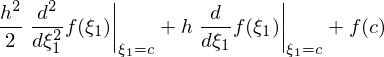

In [13]:
taylorExpansionPlus

Meaning that:

$$
f(c+h) = \frac{h^{2}}{2} \left. \frac{d^{2}}{d \xi_{1}^{2}}  f{\left (\xi_{1} \right )} \right|_{\substack{ \xi_{1}=c }} + h \left. \frac{d}{d \xi_{1}} f{\left (\xi_{1} \right )} \right|_{\substack{ \xi_{1}=c }} + f{\left (c \right )}
$$

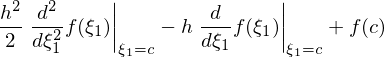

In [30]:
taylorExpansionMinus

Meaning that:

$$
f(c-h) = \frac{h^{2}}{2} \left. \frac{d^{2}}{d \xi_{1}^{2}}  f{\left (\xi_{1} \right )} \right|_{\substack{ \xi_{1}=c }} - h \left. \frac{d}{d \xi_{1}} f{\left (\xi_{1} \right )} \right|_{\substack{ \xi_{1}=c }} + f{\left (c \right )}
$$

### Solving for First and Second Derivatives

Here we can change the addition or subtraction of the two finite difference expressions to see what terms remain.  Note that each grouped expression is equal to zero.  This is assumed in Sympy.

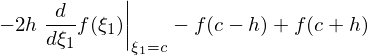

In [15]:
(taylorExpansionMinus-f(c-h))-(taylorExpansionPlus-f(c+h))

Remember that `sympy` expressions are zero by default.  So this is true:

$$
- 2 h \left. \frac{d}{d \xi_{1}} f{\left (\xi_{1} \right )} \right|_{\substack{ \xi_{1}=c }} - f{\left (c - h \right )} + f{\left (c + h \right )} = 0
$$


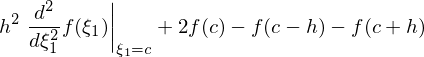

In [16]:
(taylorExpansionMinus-f(c-h))+(taylorExpansionPlus-f(c+h))

Similarly:

$$
h^{2} \left. \frac{d^{2}}{d \xi_{1}^{2}}  f{\left (\xi_{1} \right )} \right|_{\substack{ \xi_{1}=c }} + 2 f{\left (c \right )} - f{\left (c - h \right )} - f{\left (c + h \right )} = 0
$$

These are the core definitions of the finite difference calculus.  I wonder how you could produce the third and fourth derivatives?  (nudge nudge, wink wink...)

### DIY:  Discrete Derivatives

* Generate a list (grid) of data from a function such as $\sin(x)$ over the range $0$ to $2\pi$.
* Compute the derivative(s) analytically by differentiating $\sin(x)$.
* Compute the first and second derivative(s) using finite differences between $0$ and $2\pi$ from a list of discrete points and plot the error between the analytical derivative and your numerical approximation as a function of the resolution of the grid.
* Produce a visualization and a figure caption that captures a particular piece of knowledge you gained as part of this assignment.

Knowledge of some useful tools will help here:

In [ ]:
import numpy as np
print np.arange.__doc__

An example set of grid points:

In [ ]:
np.arange(0,2*np.pi,np.pi/10.0)

### DIY:  Vectorized Computations

A _list_ is one of the fundamental data structures within Python.  Numpy (a Python library) and other parts of Python libraries use _vectorized_ computations.  From Wikipedia, vectorization is "a style of computer programming where operations are applied to whole arrays instead of individual elements."  

With this in mind, we certainly _can_ iterate over our list of points and apply the function that you will soon write in an element by element fashion, however, it is a more common practice in Python and other modern languages to write vectorized code.  If this is your first exposure to vectorized computation, I recommend two initial strategies:

1.  Write out your algorithms, and
1.  Use "classic" flow control and iteration to compute the results.

From that point you will more easily see the strategy you should use to write vectorized code.  

* Using the discrete forms of the first and second derivatives (based on central differences) can you devise a vectorized operation that computes the derivative without looping in Python?

The following code snippets are a hint.  If you don't see the solution right away - write out your derivatives for each element of the array explicitly.

In [ ]:
aList = np.arange(0,2*np.pi,np.pi/10.0)

In [ ]:
aList[:]

In [ ]:
aList[3:]

In [ ]:
aList[:-3]

## Homework
----

1.  Derive the expression for the numerical approximation of the Laplacian (second derivative) in two dimensions using the appropriate definition for Taylor's series.  Some additional reading will help you do this.  Compute the analytical and numerical Laplacian for the function $f(x,y)=x^2y^2$ on a grid with spacing $\Delta x$ and $\Delta y$.  Compare the discrete calculation to the analytical calculation.
 
1.  Using what you’ve learned thus far, write down the discrete form of Fick’s law in one dimension.  Assume the data that represents compositions for any particular time is given in a list.  (Do you need to remind yourself what Fick’s law is?)  Hint: consider that you should forward difference in time and central difference in space.  Have a look at the pages in Hornbeck that are available on the wiki.

_N.B. the second part of the assignment is not difficult.  What will be challenging for you is to relate the knowledge you've gained as part of this assignment to the bigger picture of diffusion in materials.  This gap between your current state of knowledge and where I'm leading you (in problem 2) is intentional.  I would like you to discover something on your own - so I'm pointing you in a particular direction and asking you to "explore" and synthesize the information you have into something bigger!_

## Summary
----

1.  In `sympy` Taylor's series can be used to approximate functions near a point “a”.  They are constructed using the series() function.
1.  Discrete data can be used in conjunction with the Taylor series to compute derivatives when no analytical form is available.
1.  The Taylor series is used as the basis for many tasks in numerical computing so mastery of this concept, knowledge and application of Taylor's series both analytically and numerically is absolutely essential.
1.  The last bullet point is important.  Read it again.

## Looking Ahead
----

* We will be reviewing how to perform vector calculus.  
* Concepts of fields and vector fields will be introduced.
* These will be important for describing differential equations in real materials.

## Reading Assignments and Practice
----

* Schaum's handbook of mathematical tables has tables of series definitions for transcendental functions.  Our library has a digital copy that you can "check out".  Why not compare what `sympy` returns with what is listed in the tables?
* Building confidence in `sympy`'s performance is a good thing!